In [1]:
import pandas as pd

# 直接运行加载数据集
df = pd.read_csv("../data/course-12-data.csv", header=0)

# 预览前 5 行数据
df.head()

,X0,X1,Y
0,5.1,3.5,-1
1,4.9,3.0,-1
2,4.7,3.2,-1
3,4.6,3.1,-1
4,5.0,3.6,-1


## 将数组转换为常量张量

tf.cast 是 TensorFlow 中的一个函数，用于执行张量数据类型的转换。它的作用是将张量的数据类型转换为指定的数据类型。

In [2]:
import tensorflow as tf

# 将数组转换为常量张量
X = tf.cast(tf.constant(df[['X0', 'X1']].values), tf.float32)
y = tf.constant(df[['Y']].values)

X.shape, y.shape

/Users/yilonghao/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


(TensorShape([150, 2]), TensorShape([150, 1]))

## 定义模型类

tf.Variable 是 TensorFlow 中用于表示可变张量的类。可变张量是指可以通过 TensorFlow 的计算图进行修改的张量，通常用于表示模型参数或其他可训练的变量。

使用 tf.Variable 时，你可以在 TensorFlow 的计算图中进行张量的创建和修改，而且 TensorFlow 会自动跟踪这些修改，以便在进行反向传播时更新相应的梯度。

In [3]:
class Model(object):
    def __init__(self):
        # 初始化权重全为 1，也可以随机初始化
        # 选择变量张量，因为权重后续会不断迭代更新
        self.W1 = tf.Variable(tf.ones([2, 3]))
        self.W2 = tf.Variable(tf.ones([3, 1]))

    def __call__(self, x):
        hidden_layer = tf.nn.sigmoid(tf.linalg.matmul(X, self.W1))  # 隐含层前向传播
        y_ = tf.nn.sigmoid(tf.linalg.matmul(hidden_layer, self.W2))  # 输出层前向传播
        return y_

In [4]:
model = Model()  # 实例化类
y_ = model(X)  # 测试输入
y_.shape  # 输出

TensorShape([150, 1])

In [5]:
def loss_fn(model, X, y):
    """计算loss"""
    y_ = model(X)  # 前向传播得到预测值
    # 使用 MSE 损失函数，并使用 reduce_mean 计算样本总损失
    loss = tf.reduce_mean(tf.compat.v1.losses.mean_squared_error(y, y_))
    return loss

In [6]:
loss = loss_fn(model, X, y)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.2723011>

## 迭代训练

In [7]:
EPOCHS = 200  # 迭代 200 次
LEARNING_RATE = 0.1  # 学习率

for epoch in range(EPOCHS):
    # 使用 GradientTape 追踪梯度
    with tf.GradientTape() as tape:
        loss = loss_fn(model, X, y)  # 计算 Loss，包含前向传播过程
    # 使用梯度下降法优化迭代
    # 输出模型需优化参数 W1，W2 自动微分结果
    dW1, dW2 = tape.gradient(loss, [model.W1, model.W2])
    model.W1.assign_sub(LEARNING_RATE * dW1)  # 更新梯度
    model.W2.assign_sub(LEARNING_RATE * dW2)

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f'Epoch [000/{EPOCHS}], Loss: [{loss:.4f}]')
    elif (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: [{loss:.4f}]')

Epoch [000/200], Loss: [1.2723]
Epoch [100/200], Loss: [0.9051]
Epoch [200/200], Loss: [0.8889]


## 使用 TensorFlow 优化器

In [8]:
# 定义 SGD 优化器，设定学习率，
optimizer = tf.optimizers.SGD(learning_rate=0.1)
optimizer

In [9]:
loss_list = []  # 存放每一次 loss
model = Model()  # 实例化类
for epoch in range(EPOCHS):
    # 使用 GradientTape 追踪梯度
    with tf.GradientTape() as tape:
        loss = loss_fn(model, X, y)  # 计算 Loss，包含前向传播过程
        loss_list.append(loss)  # 保存每次迭代 loss

    grads = tape.gradient(loss, [model.W1, model.W2])  # 输出自动微分结果
    optimizer.apply_gradients(zip(grads, [model.W1, model.W2]))  # 使用优化器更新梯度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f'Epoch [000/{EPOCHS}], Loss: [{loss:.4f}]')
    elif (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: [{loss:.4f}]')

Epoch [000/200], Loss: [1.2723]
Epoch [100/200], Loss: [0.9051]


Epoch [200/200], Loss: [0.8889]


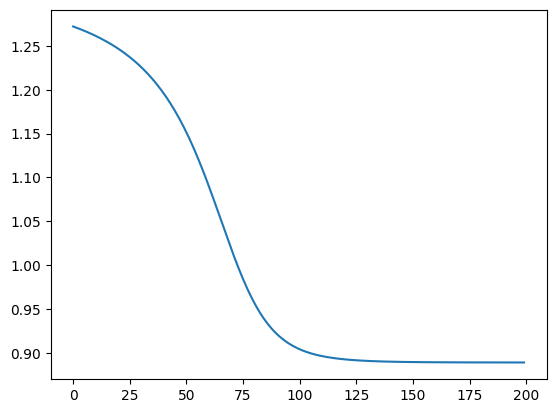

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(loss_list)  # 绘制 loss 变化图像